# Lesson 8. Pulling it all Together
In this lesson we're going to pull everything we've learned together and answer the question: 
- How many polling stations are in each census tract?
- Which polling stations are within walking distance (100m) from a bus route?
- How far are these polling stations from the bus routes in each tract on average?

### Install Packages

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

## 8.1 Polling Station Locations

In [2]:
# Pull in polling location
polling_ac_df = pd.read_csv('notebook_data/ac_voting_locations.csv')
polling_ac_df.head()

,CITY,NAME,ADDRESS,STATE,ZIP,X,Y
0,ALAMEDA,GRACEPOINT CHURCH,1275 HARBOR BAY PWKY,CA,94502,-122.229540,37.728010
1,ALAMEDA,ALMANAC BEER CO.,651 W TOWER AVE,CA,94501,-122.306330,37.783375
2,ALAMEDA,LINCOLN MIDDLE SCHOOL,1250 FERNSIDE BLVD,CA,94501,-122.231660,37.753357
3,ALAMEDA,SOUTH SHORE CENTER,2130 OTIS DRIVE,CA,94501,-122.252850,37.760136
4,ALAMEDA,ALAMEDA HIGH SCHOOL,2201 ENCINAL AVE,CA,94501,-122.248241,37.769054


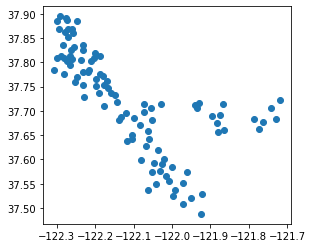

In [3]:
# Make into geo data frame
polling_ac_gdf = gpd.GeoDataFrame(polling_ac_df, 
                               geometry=gpd.points_from_xy(polling_ac_df.X, polling_ac_df.Y))
polling_ac_gdf.crs = "epsg:4326"

polling_ac_gdf.plot()

## 8.2 Tracts data

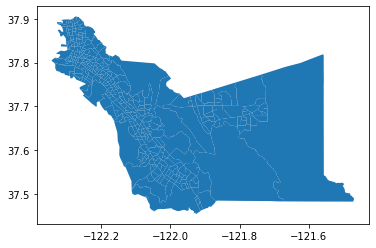

In [4]:
# Bring in census tracts
tracts_gdf = gpd.read_file("zip://notebook_data/census/Tracts/cb_2013_06_tract_500k.zip")

tracts_gdf_ac = tracts_gdf[tracts_gdf['COUNTYFP']=='001']
tracts_gdf_ac.plot()
plt.show()

In [5]:
# spatial join polling station and census tract
print('polling_ac_gdf:', polling_ac_gdf.crs)
print('tracts_gdf_ac CRS:', tracts_gdf_ac.crs)

polling_ac_gdf: epsg:4326
tracts_gdf_ac CRS: epsg:4269


In [6]:
polling_ac_gdf_utm10 = polling_ac_gdf.to_crs("epsg:26910")
tracts_gdf_ac_utm10 = tracts_gdf_ac.to_crs("epsg:26910")

# 8.3 Spatial Join

In [7]:
polls_jointracts = gpd.sjoin(tracts_gdf_ac_utm10, polling_ac_gdf_utm10, how='left')

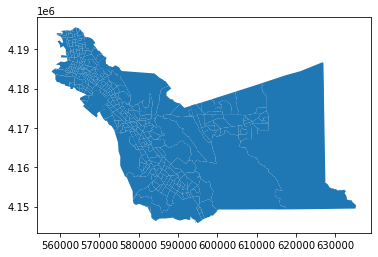

In [8]:
polls_jointracts.plot()

In [9]:
polls_jointracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME_left,LSAD,ALAND,AWATER,geometry,index_right,CITY,NAME_right,ADDRESS,STATE,ZIP,X,Y
0,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,"POLYGON ((564744.993 4188317.651, 564946.532 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((562861.148 4188278.725, 563070.421 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06,001,402200,1400000US06001402200,06001402200,4022,CT,712082,0,"POLYGON ((561264.509 4184672.770, 561409.095 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06,001,402800,1400000US06001402800,06001402800,4028,CT,398311,0,"POLYGON ((563734.437 4184562.158, 563961.943 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06,001,404800,1400000US06001404800,06001404800,4048,CT,628405,0,"POLYGON ((568821.460 4184008.066, 569030.992 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
polls_jointracts.shape

(366, 18)

## 8.4 Aggregate number of stations by census tracts

In [11]:
# aggreagate to find number of polling stations in census tract
polls_countsbytract = polls_jointracts[['TRACTCE', 'NAME_right', 'geometry']].dissolve(by='TRACTCE', aggfunc='count').reset_index()
polls_countsbytract.head()

,TRACTCE,geometry,NAME_right
0,400100,"POLYGON ((566221.610 4193371.510, 566659.969 4...",1
1,400200,"POLYGON ((565335.837 4188666.188, 565441.159 4...",0
2,400300,"POLYGON ((564744.993 4188317.651, 564946.532 4...",0
3,400400,"POLYGON ((564950.988 4188518.225, 564992.933 4...",0
4,400500,"POLYGON ((564276.448 4189213.844, 564317.359 4...",0


In [12]:
polls_countsbytract.rename(columns={'NAME_right': 'Num_Polling'}, inplace=True)

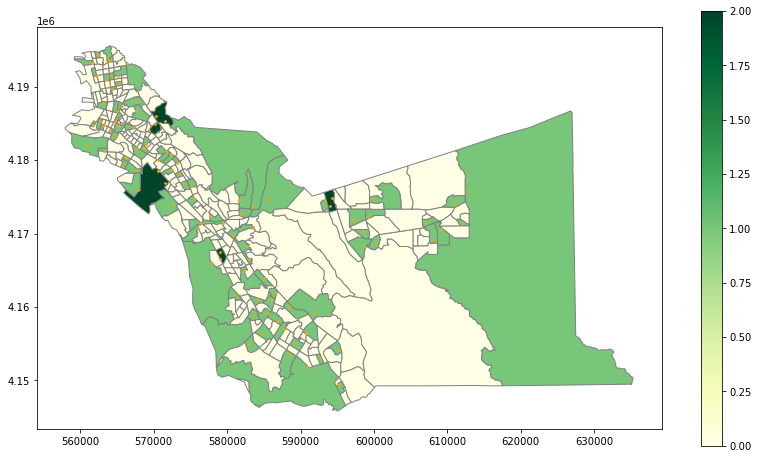

In [13]:
fig, ax = plt.subplots(figsize = (14,8)) 

# Display the output of our spatial join
polls_countsbytract.plot(ax=ax,column='Num_Polling', 
                         cmap="YlGn",
                         edgecolor="grey",
                         legend=True)
polling_ac_gdf_utm10.plot(ax=ax, color='orange', edgecolor='black', markersize=3)

## 8.3 Attribute join back to tracts data

In [14]:
# merge onto census tract data
tracts_gdf_ac =  tracts_gdf_ac.merge(polls_countsbytract[['TRACTCE', 'Num_Polling']], left_on='TRACTCE',right_on="TRACTCE", how='inner') 
tracts_gdf_ac.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,Num_Polling
0,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,"POLYGON ((-122.26416 37.84000, -122.26186 37.8...",0
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.28558 37.83978, -122.28319 37.8...",0
2,06,001,402200,1400000US06001402200,06001402200,4022,CT,712082,0,"POLYGON ((-122.30403 37.80739, -122.30239 37.8...",0
3,06,001,402800,1400000US06001402800,06001402800,4028,CT,398311,0,"POLYGON ((-122.27598 37.80622, -122.27335 37.8...",0
4,06,001,404800,1400000US06001404800,06001404800,4048,CT,628405,0,"POLYGON ((-122.21825 37.80086, -122.21582 37.8...",0


## 8.4 Berkeley outline

In [15]:
berkeley_places = gpd.read_file("outdata/berkeley_places.shp")
berkeley_places.crs
berkeley_places_utm10 = berkeley_places.to_crs("epsg:26910")

## 8.5 Bus routes

In [16]:
bus_routes = gpd.read_file('zip://notebook_data/transportation/Fall20Routeshape.zip')
bus_routes_utm10 = bus_routes.to_crs("epsg:26910")
bus_routes_utm10.head()

,PUB_RTE,geometry
0,10,"MULTILINESTRING ((580518.766 4169609.301, 5805..."
1,12,"MULTILINESTRING ((564130.667 4183230.975, 5641..."
2,14,"MULTILINESTRING ((568559.855 4180881.628, 5684..."
3,18,"MULTILINESTRING ((564061.643 4184157.707, 5640..."
4,19,"MULTILINESTRING ((570014.131 4179614.966, 5700..."


In [17]:
bus_routes_berkeley = bus_routes_utm10.intersects(berkeley_places_utm10.geometry.squeeze())

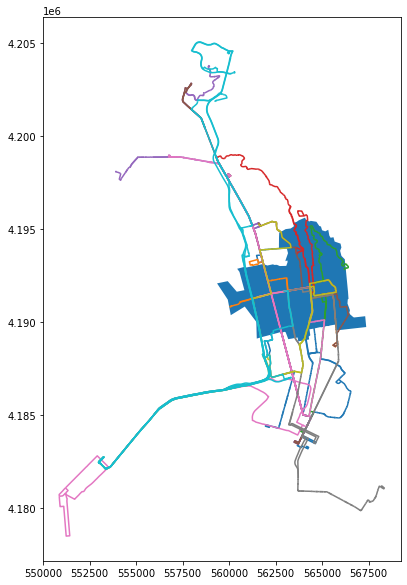

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_places_utm10.plot(ax=ax)
bus_routes_utm10.loc[bus_routes_berkeley].plot(ax=ax, column ='PUB_RTE')

In [19]:
bus_berk = bus_routes_utm10.loc[bus_routes_berkeley].reset_index(drop=True)

In [27]:
bus_berk.length

0     27368.944015
1     23898.448595
2     21570.549775
3     16627.495763
4     12965.947917
5     14664.333589
6     11170.473748
7      7980.574937
8     21874.714230
9     48622.938153
10    44042.351997
11    40600.003845
12    16763.564215
13    80557.372223
14    15623.750816
15    31191.521786
16    19639.088165
17    43795.999739
18    23495.092877
19    36027.037683
20    57200.575339
21    72300.818317
dtype: float64

In [20]:
bus_berk_clip = gpd.clip(bus_berk,berkeley_places_utm10)

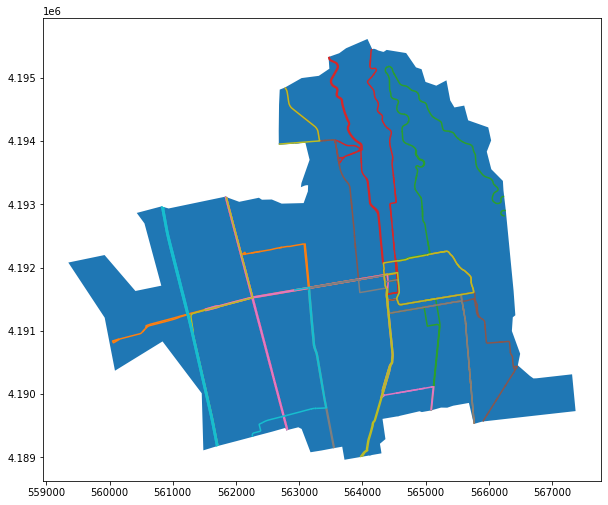

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_places_utm10.plot(ax=ax)
bus_berk_clip.plot(ax=ax, column ='PUB_RTE')

## 8.6 Polling stations within walking distance of bus routes

In [22]:
bus_berk_buf =bus_berk_clip.buffer(distance=100)

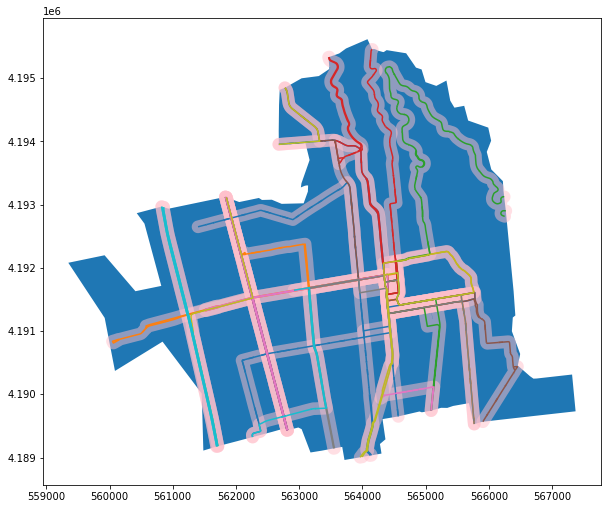

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_places_utm10.plot(ax=ax)
bus_berk_buf .plot(color='pink', ax=ax, alpha=0.5)
bus_berk_clip.plot(ax=ax, column ='PUB_RTE')

In [24]:
polling_berk = polling_ac_gdf_utm10.intersects(berkeley_places_utm10.geometry.squeeze())

polling_berk_gdf = polling_ac_gdf_utm10[polling_berk].reset_index(drop=True)

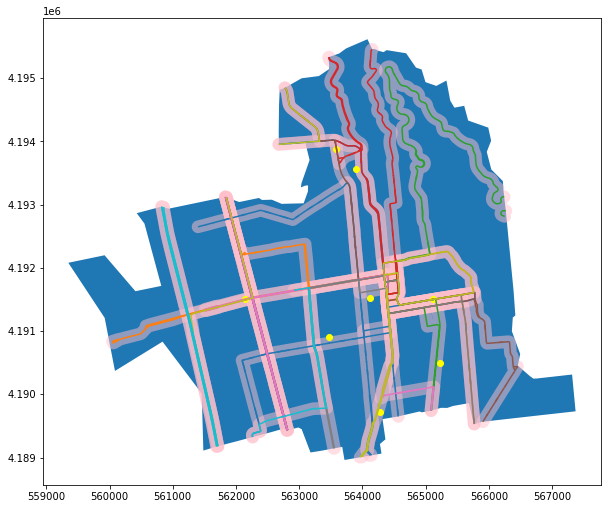

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_places_utm10.plot(ax=ax)
bus_berk_buf.plot(color='pink', ax=ax, alpha=0.5)
bus_berk_clip.plot(ax=ax, column ='PUB_RTE')
polling_berk_gdf.plot(ax=ax, color= 'yellow')

## 8.7 Polling station distance from bus routes

In [26]:
polling_berk_gdf.distance(bus_berk_clip.unary_union)

0    100.172870
1     33.260299
2     89.930822
3      3.987569
4      1.714482
5      0.836052
6     92.734879
7     51.423725
dtype: float64

---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="../assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
        


